# Table of Contents
 <p>

In [2]:
import pandas as pd
import numpy as np
import scipy as scipy
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import os
import matplotlib.patches as mpatches
import pretty_table as pt

# import own libraries
import pretty_table as pretty
import plot_simulations as sim
import phenomodel as pheno

# plotting settings
import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

# more parameters
mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [3]:
def find_k_min(input_var):
    """An algorithm to find the minimal set for initialization of a `model`"""
    a = np.zeros(7)
    if input_var[6] > 0:
        a[6] = input_var[6]
        return a
    elif (input_var[3:6] > 0).any():
        a[3:6] = input_var[3:6]
        return a
    else:
        return input_var

In [4]:
def iterate(M_obs, N_A, N_B, N_C, N_T, k_min, fn=0.1, fp=0.1, alpha=5, max_iter=10):
    """
    Progressively refines an object until the object converges or iterations exceed a maximum.
    """
    min_model = pheno.Model(N_A, N_B, N_C, N_T, *k_min, fn=fn, fp=fp)
    min_model.signal_threshold(alpha)
    min_model.test_classes(M_obs.M)

    x = True
    prev_model = min_model
    i = 0
    while x:
        curr_model = pheno.Model(N_A, N_B, N_C, N_T,
                                 *prev_model.accepted,
                                 fn=fn, fp=fp)
        curr_model.signal_threshold(alpha)
        curr_model.test_classes(M_obs.M)

        if (curr_model.accepted == prev_model.accepted).all():
            x = False
        else:
            prev_model = curr_model
        i += 1
        if i > max_iter:
            x = False
            print('Warning, maximum number of iterations exceeded, terminating prematurely.')

    return curr_model

In [5]:
def random_set():
    """
    Generates a random set of M_ijk (without noise), and N_ijk values.
    """
    real = np.random.randint(0, 2, 7)
    # prevent all 0's
    while np.sum(real) < 3:
        real = np.random.randint(0, 2, 7)

    m_coeffs = np.random.randint(10, 2000, 7)
    m_coeffs[np.where(real == 0)] = 0
    
    N_A = m_coeffs[0] + m_coeffs[3] + m_coeffs[4]  + m_coeffs[6]
    N_B = m_coeffs[1] + m_coeffs[3] + m_coeffs[5]  + m_coeffs[6]
    N_C = m_coeffs[2] + m_coeffs[4] + m_coeffs[5]  + m_coeffs[6]
    N_T = 21000
    
    N = [N_A, N_B, N_C, N_T]
    
    return N, m_coeffs

def noise_model(N, m_coeffs, fn, fp):
    """Given a genome size, N, class sizes and false rates, returns a `model` of a noised M_ijk matrix. 
    """
    M = pheno.Model(*N, *m_coeffs, fn=fn, fp=fp)
    if (fp == 0) & (fn == 0):
        M_mat = M.M
    else:
        M_mat = M.M + np.random.normal(M.fps, np.abs(M.fps) + 5) + \
                      np.random.normal(M.fns, np.abs(M.fns) + 5)
        M_mat[np.where(M_mat < 0)] = 0

    m_vector = (M_mat[1,0,0], M_mat[0,1,0],
                M_mat[0,0,1], M_mat[1,1,0], M_mat[1,0,1],
                M_mat[0,1,1], M_mat[1,1,1])
    noisy_m_coeffs = np.array([M_mat[1,0,0], M_mat[0,1,0],
                               M_mat[0,0,1], M_mat[1,1,0], M_mat[1,0,1],
                               M_mat[0,1,1], M_mat[1,1,1]])
    M_obs = pheno.Model(*N, *m_vector, fn=0, fp=0)

    return M_obs, noisy_m_coeffs

def check_truth(i, accepted_ms, m_coeffs):
    if m_coeffs == 0:
        if accepted_ms[i] == 0:
            return 'true_0'
        else:
            return 'false_0'
    else:
        if accepted_ms[i] > 0:
            return 'true_1'
        else:
            return 'false_1'

def loop(alpha=5, fp=0.1, fn=0.1):
    N, m_coeffs = random_set()
    M_obs, noisy_m_coeffs = noise_model(N, m_coeffs, fp=fp, fn=fn)
    k_min = find_k_min(m_coeffs)
    final = iterate(M_obs, *N, k_min, alpha=alpha, fp=fp, fn=fn)
    calls = np.chararray(7, itemsize=7)
    for i, c in enumerate(m_coeffs):
        calls[i] = check_truth(i, final.accepted, c)

    return m_coeffs, noisy_m_coeffs, final.signal, calls

In [6]:
def run(alpha, fp, fn, iters=1000):
    """Implements the false-hit algorithm `iters` times with random initializations"""
    iters = iters
    real_M = np.empty(shape=(iters, 7))
    noisy_M = np.empty(shape=(iters, 7))
    classifications = np.empty(shape=(iters, 7))
    signals = np.empty(shape=(iters, 7))
    calls = np.chararray(shape=(iters, 7), itemsize=7)
    for i in range(iters):
        packed_vars = loop(alpha=alpha, fp=fp, fn=fn)
        m_coeffs, noisy_m_coeffs, signal, call = packed_vars
        real_M[i, :] = m_coeffs
        noisy_M[i, :] = noisy_m_coeffs
        signals[i, :] = signal
        calls[i, :] = call
    return real_M, signals, calls, noisy_M

In [8]:
def study(alpha, fp, fn, iters=1000):
    packed_vars = run(alpha, fp, fn, iters)
    real_M, signals, calls, noisy_M = packed_vars
    normed_signals = signals/np.std(signals)
    normed_signals[np.abs(normed_signals) > 10*alpha/np.std(signals)] = 1
    fig, ax = sim.make_pretty_plots(noisy_M, real_M, normed_signals, calls, iters, alpha=0.2)
    fig.suptitle('Params: alpha={0}, q={1}, f={2}'.format(alpha, fp, fn),
                 fontsize=18)

    def freq(calls):
        cols = [0, 3, 6]
        full = ['Full']
        empty = ['Empty']
        for i in range(3):
            c = calls[:, cols[i]]
            l=len(c)
            true0 = len(c[np.where(c == b'true_0')])/l
            true1 = len(c[np.where(c == b'true_1')])/l
            false0 = len(c[np.where(c == b'false_0')])/l
            false1 = len(c[np.where(c == b'false_1')])/l

            true0 = true0/(true0 + false0)
            true1 = true1/(true1 + false1)
            full += ['{0:.2g}'.format(true1)]
            empty += ['{0:.2g}'.format(true0)]
        print('fraction of categories correctly classified:')
        pt.table_print(['category', 'M100', 'M110', 'M111'])
        pt.table_print(full)
        pt.table_print(empty)
    
    freq(calls)
        
    return fig, ax

fraction of categories correctly classified:
category            M100                M110                M111                
Full                1                   1                   1                   
Empty               1                   1                   1                   


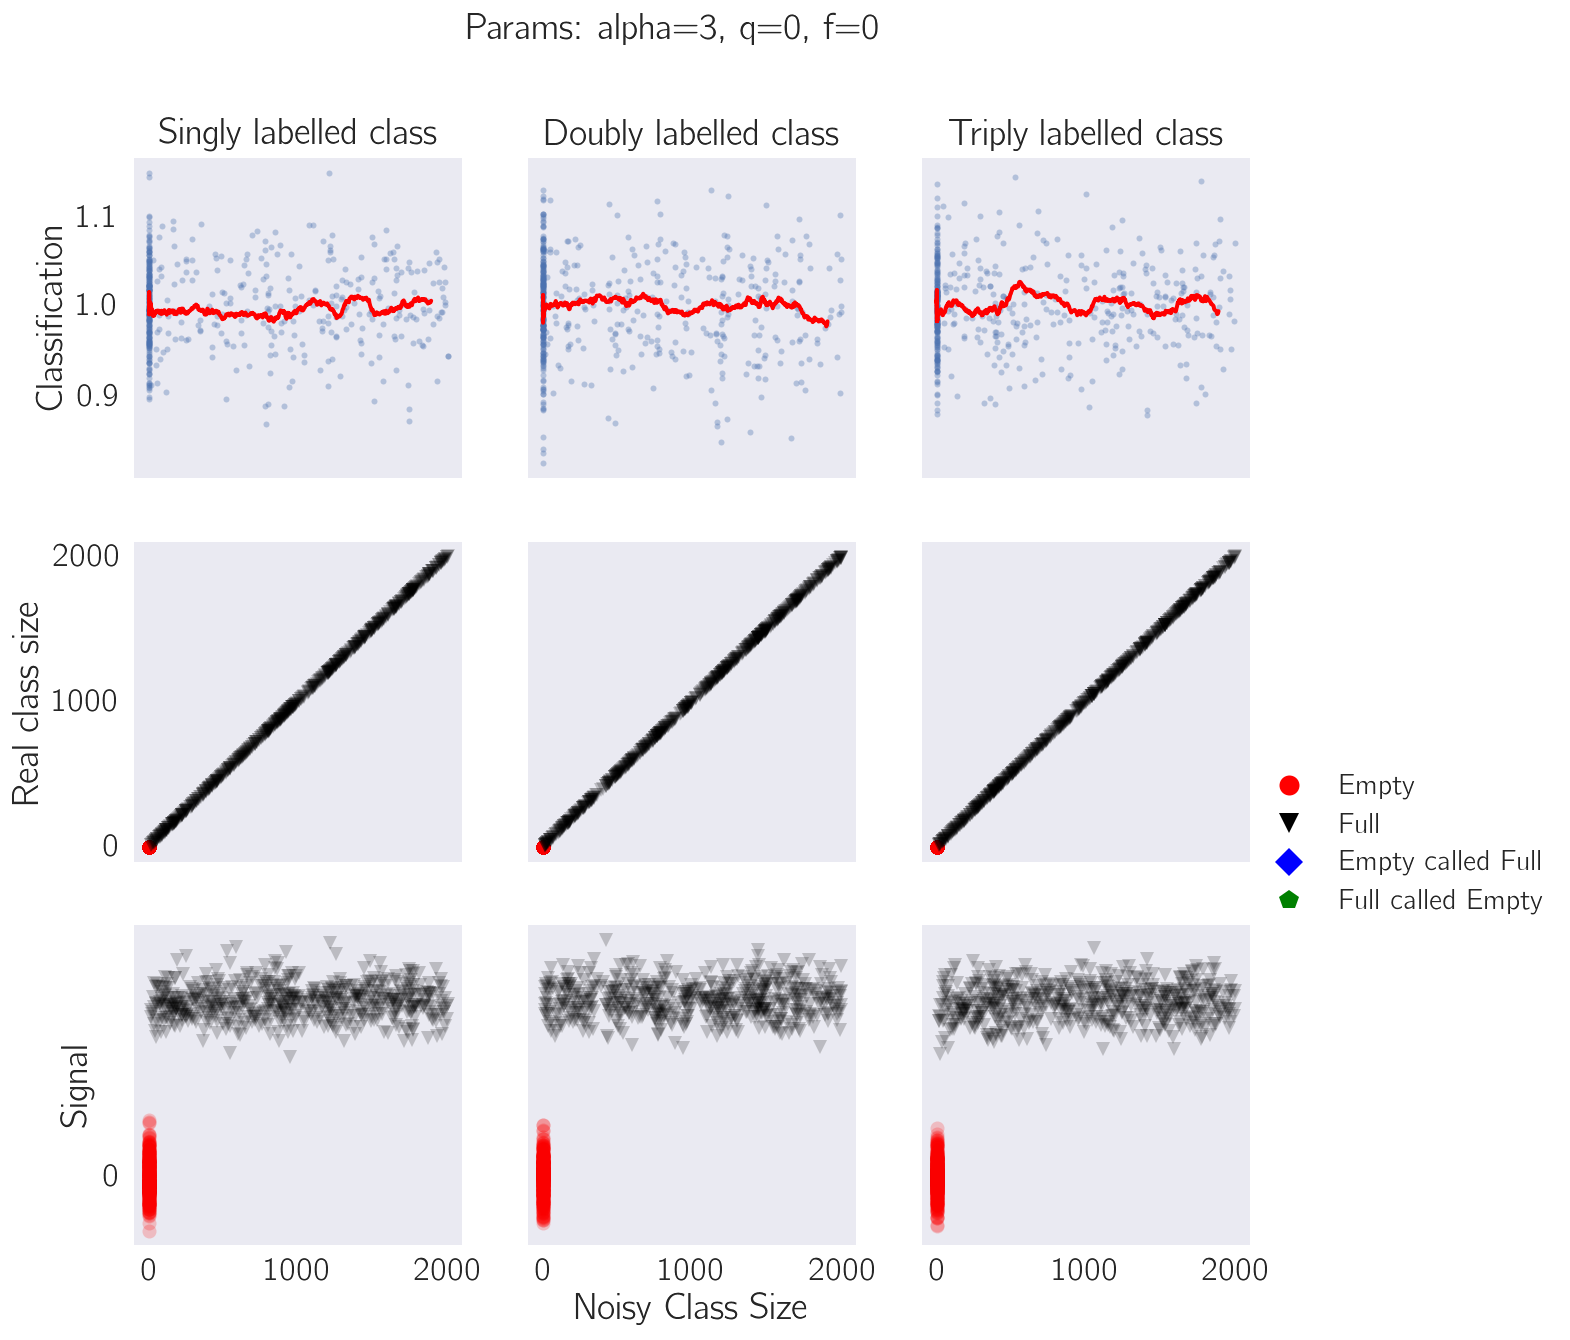

In [9]:
fig, ax = study(3, 0, 0)

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.8                 0.98                0.98                
Empty               0.94                0.78                0.83                


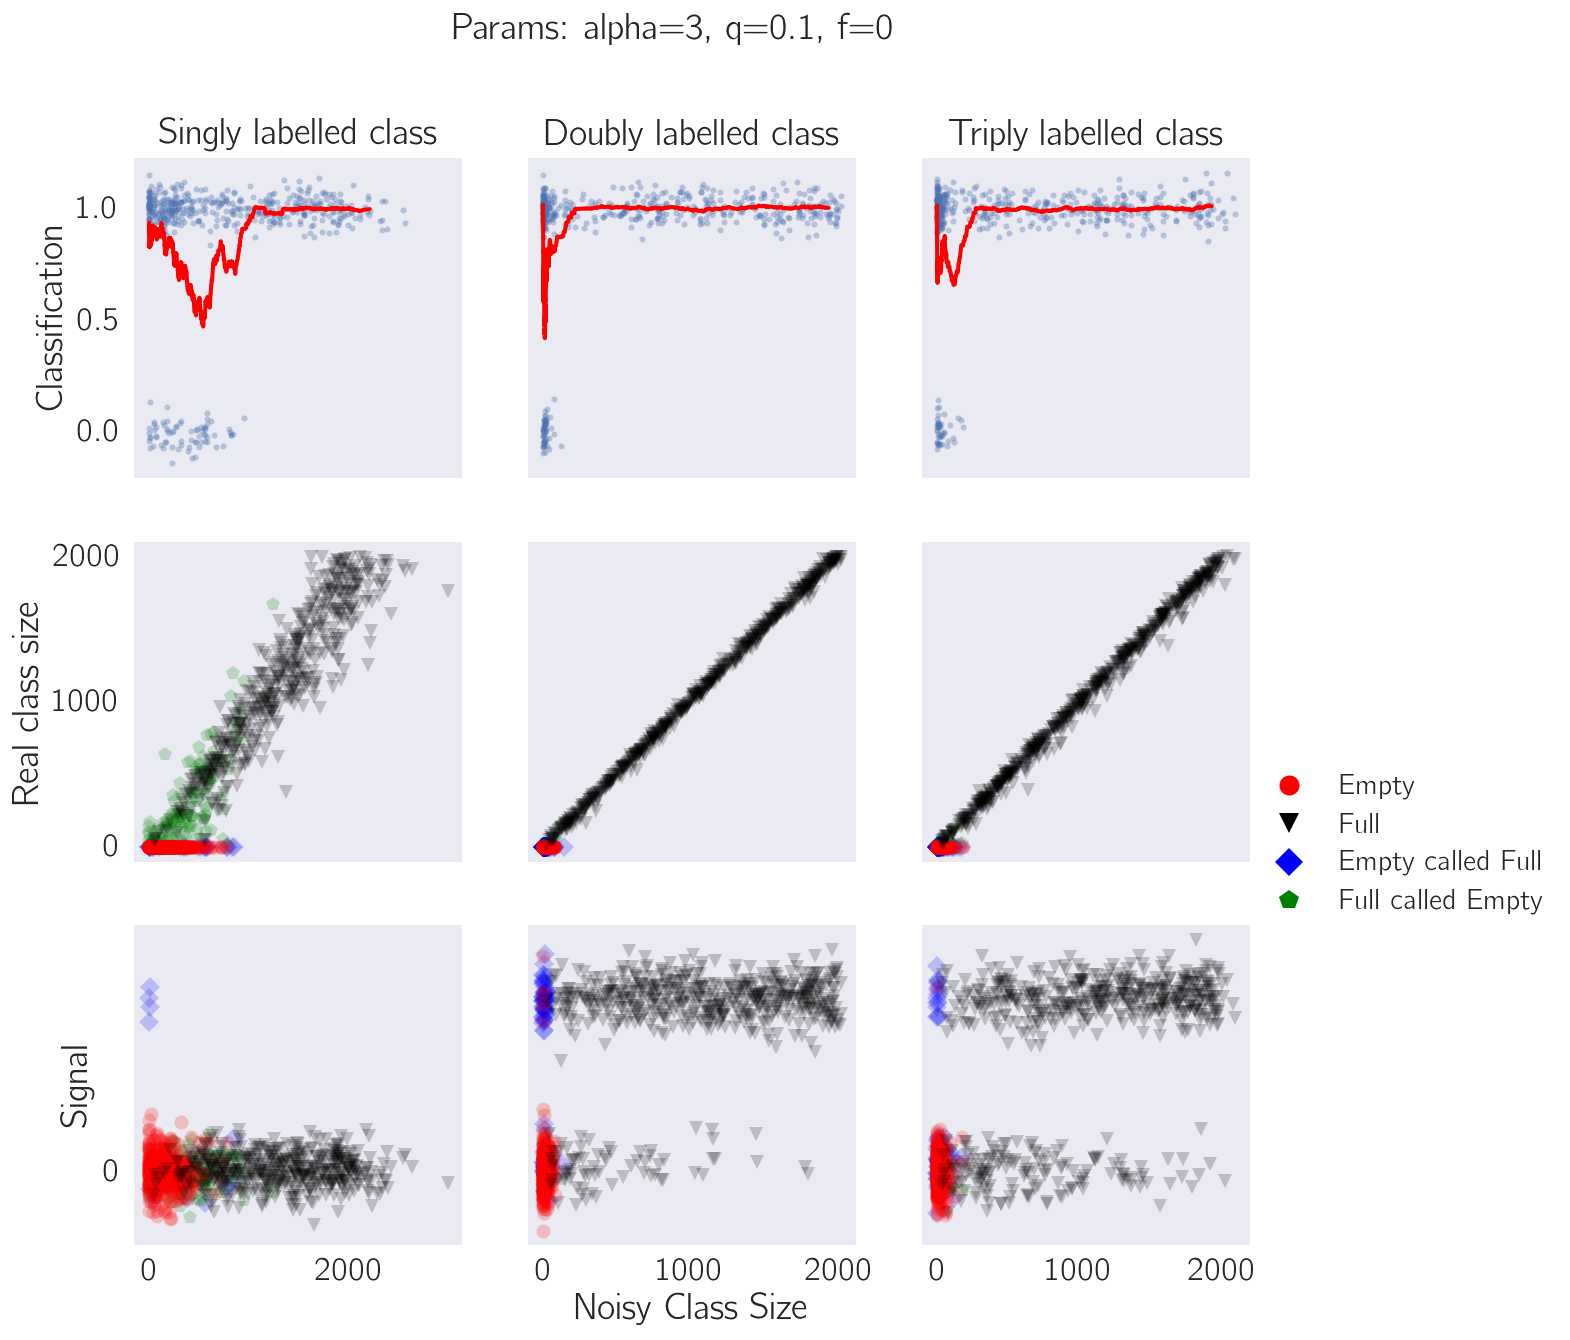

In [10]:
fig, ax = study(3, 0.1, 0)

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.8                 0.99                0.98                
Empty               0.81                0.74                0.77                


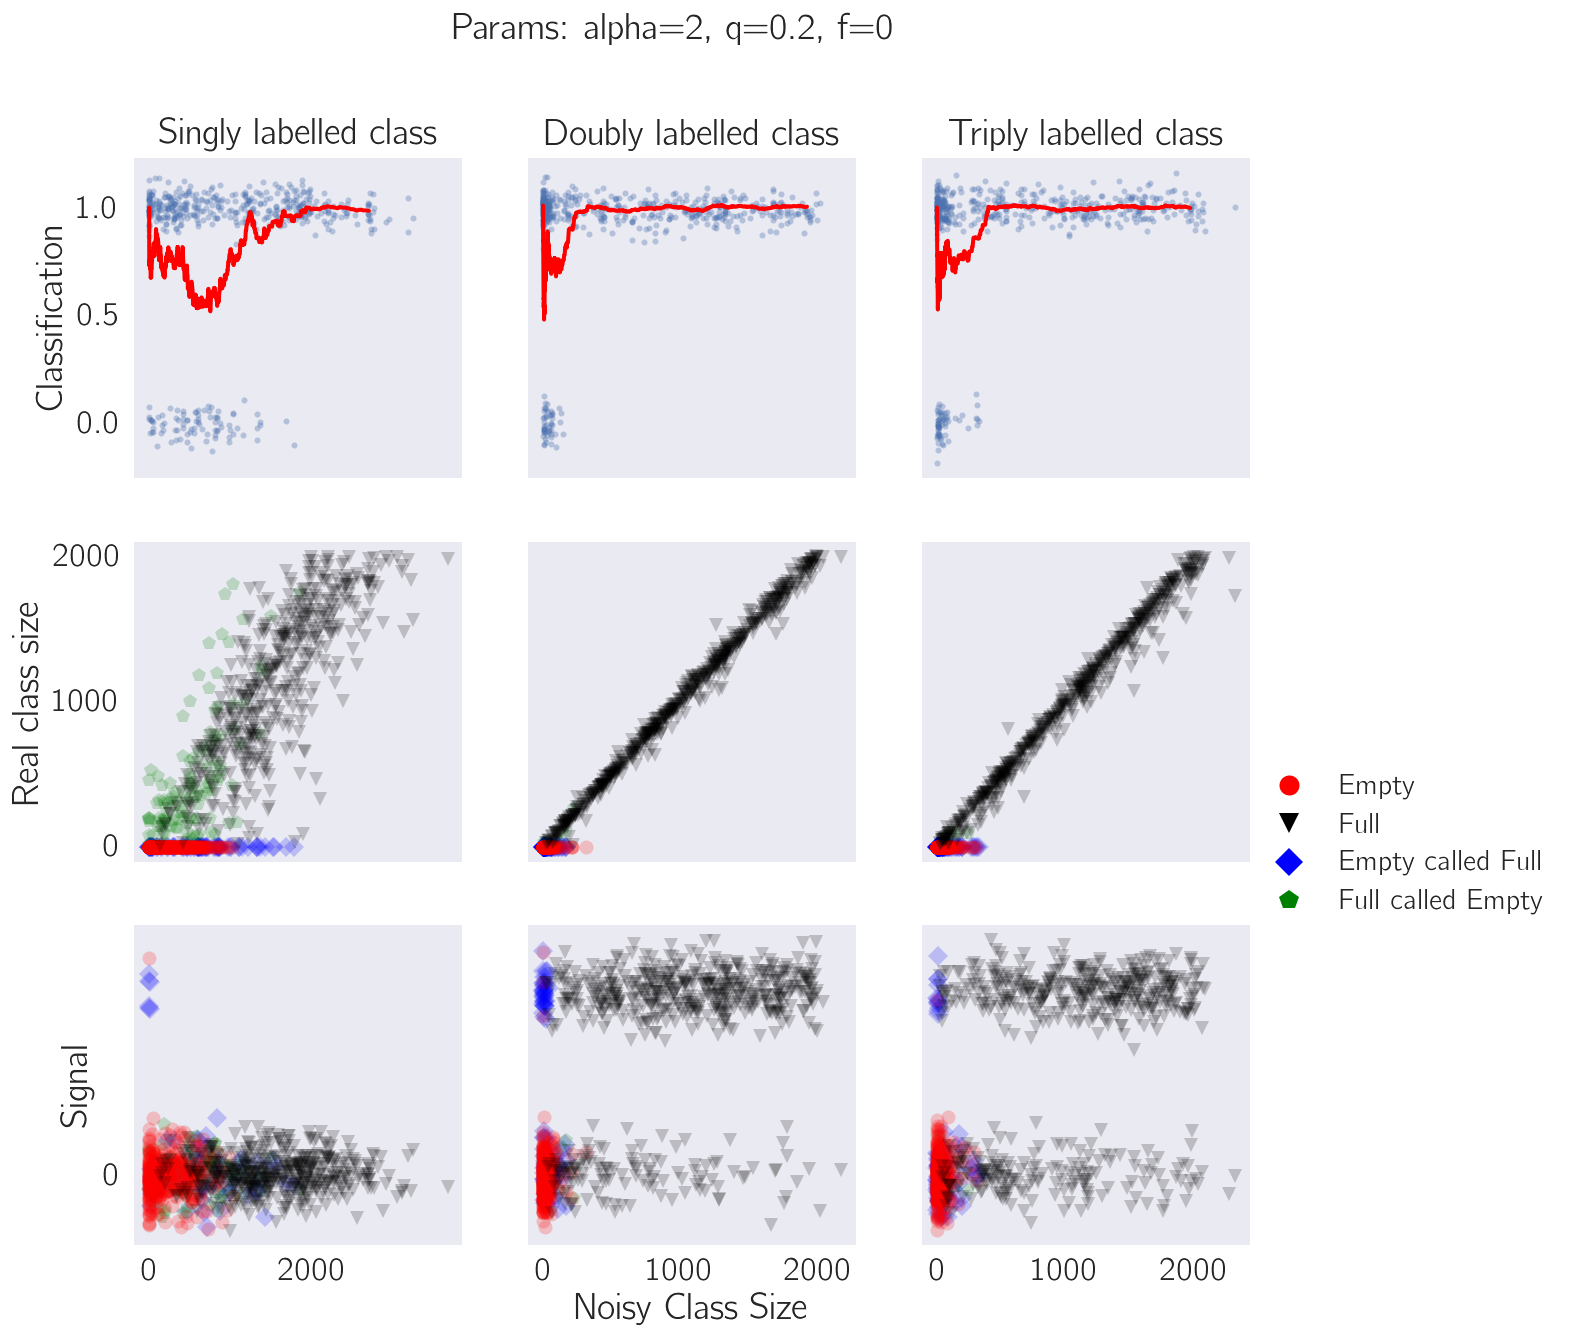

In [28]:
fig, ax = study(2, 0.2, 0)

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.54                0.98                0.98                
Empty               0.97                0.71                0.87                


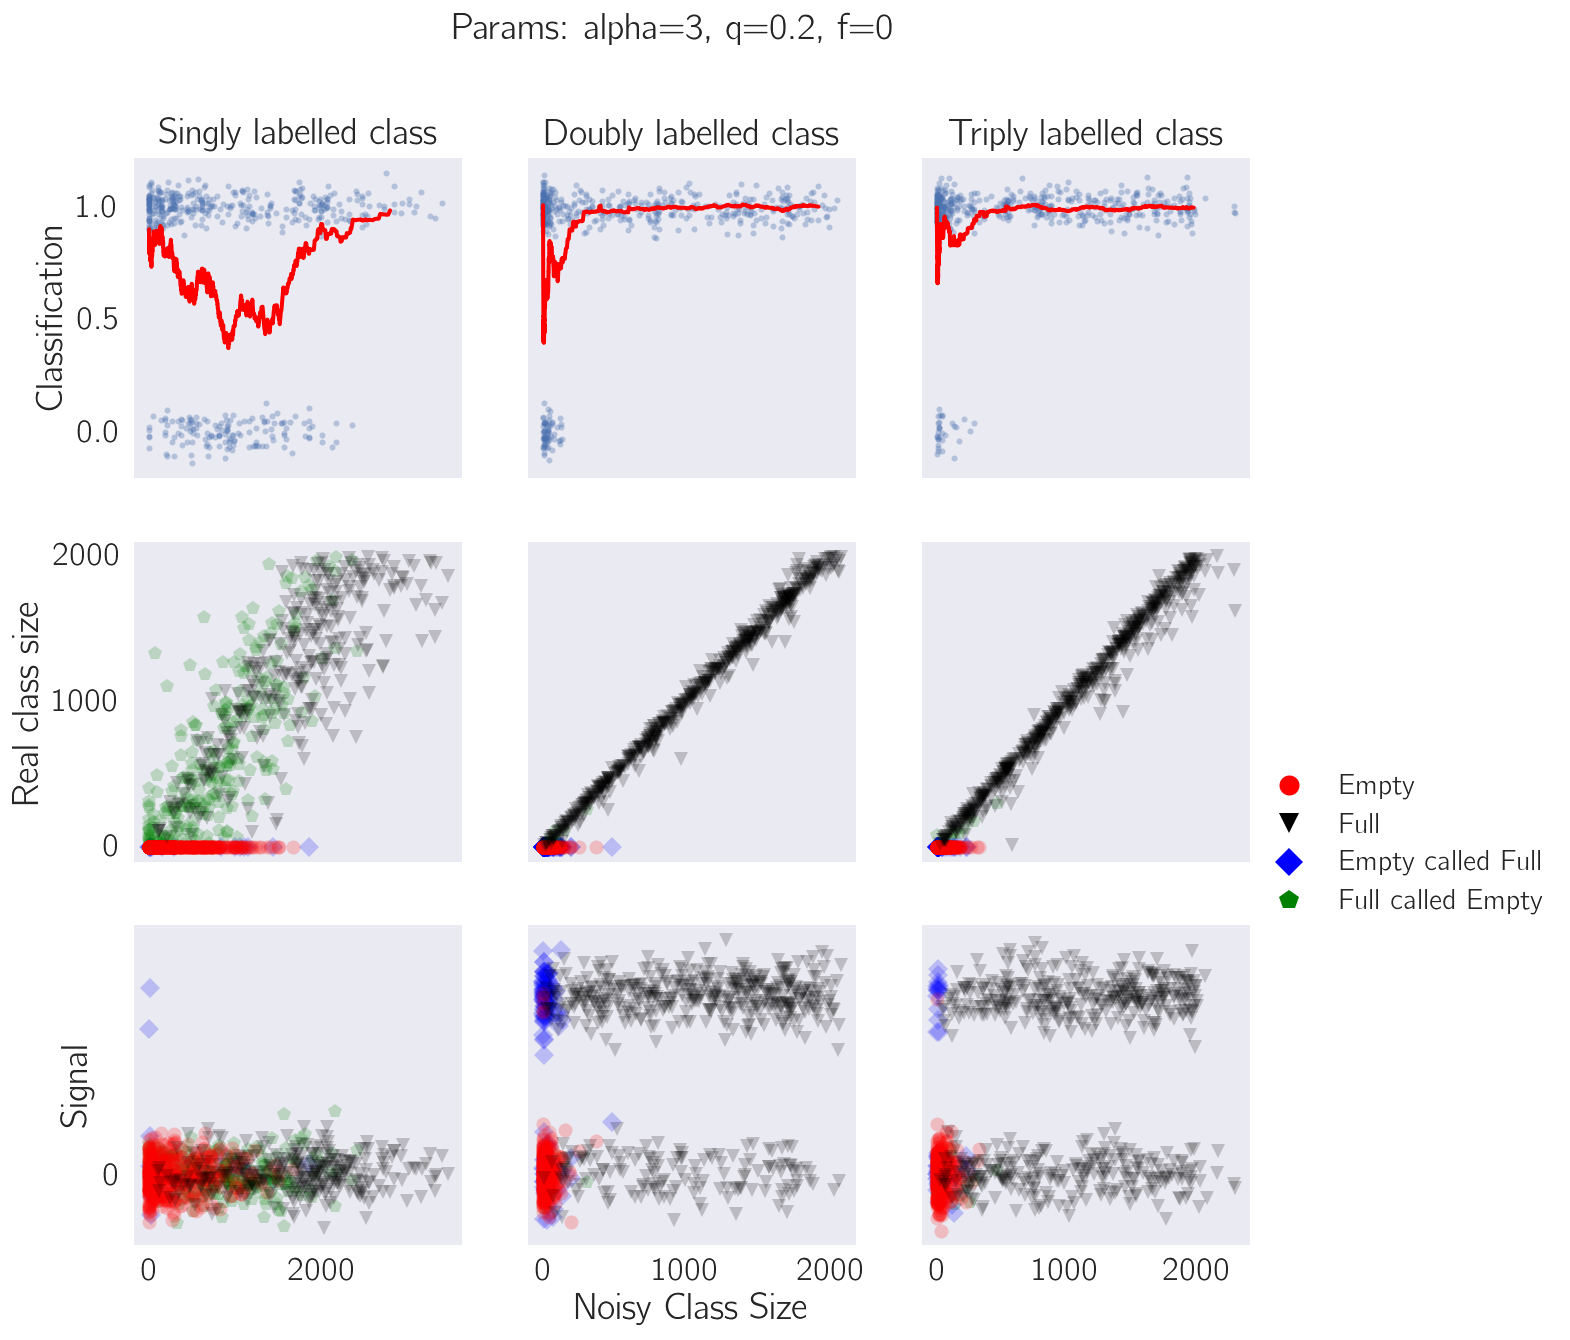

In [26]:
fig, ax = study(3, 0.2, 0)

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.99                0.99                1                   
Empty               0.75                0.68                0.52                


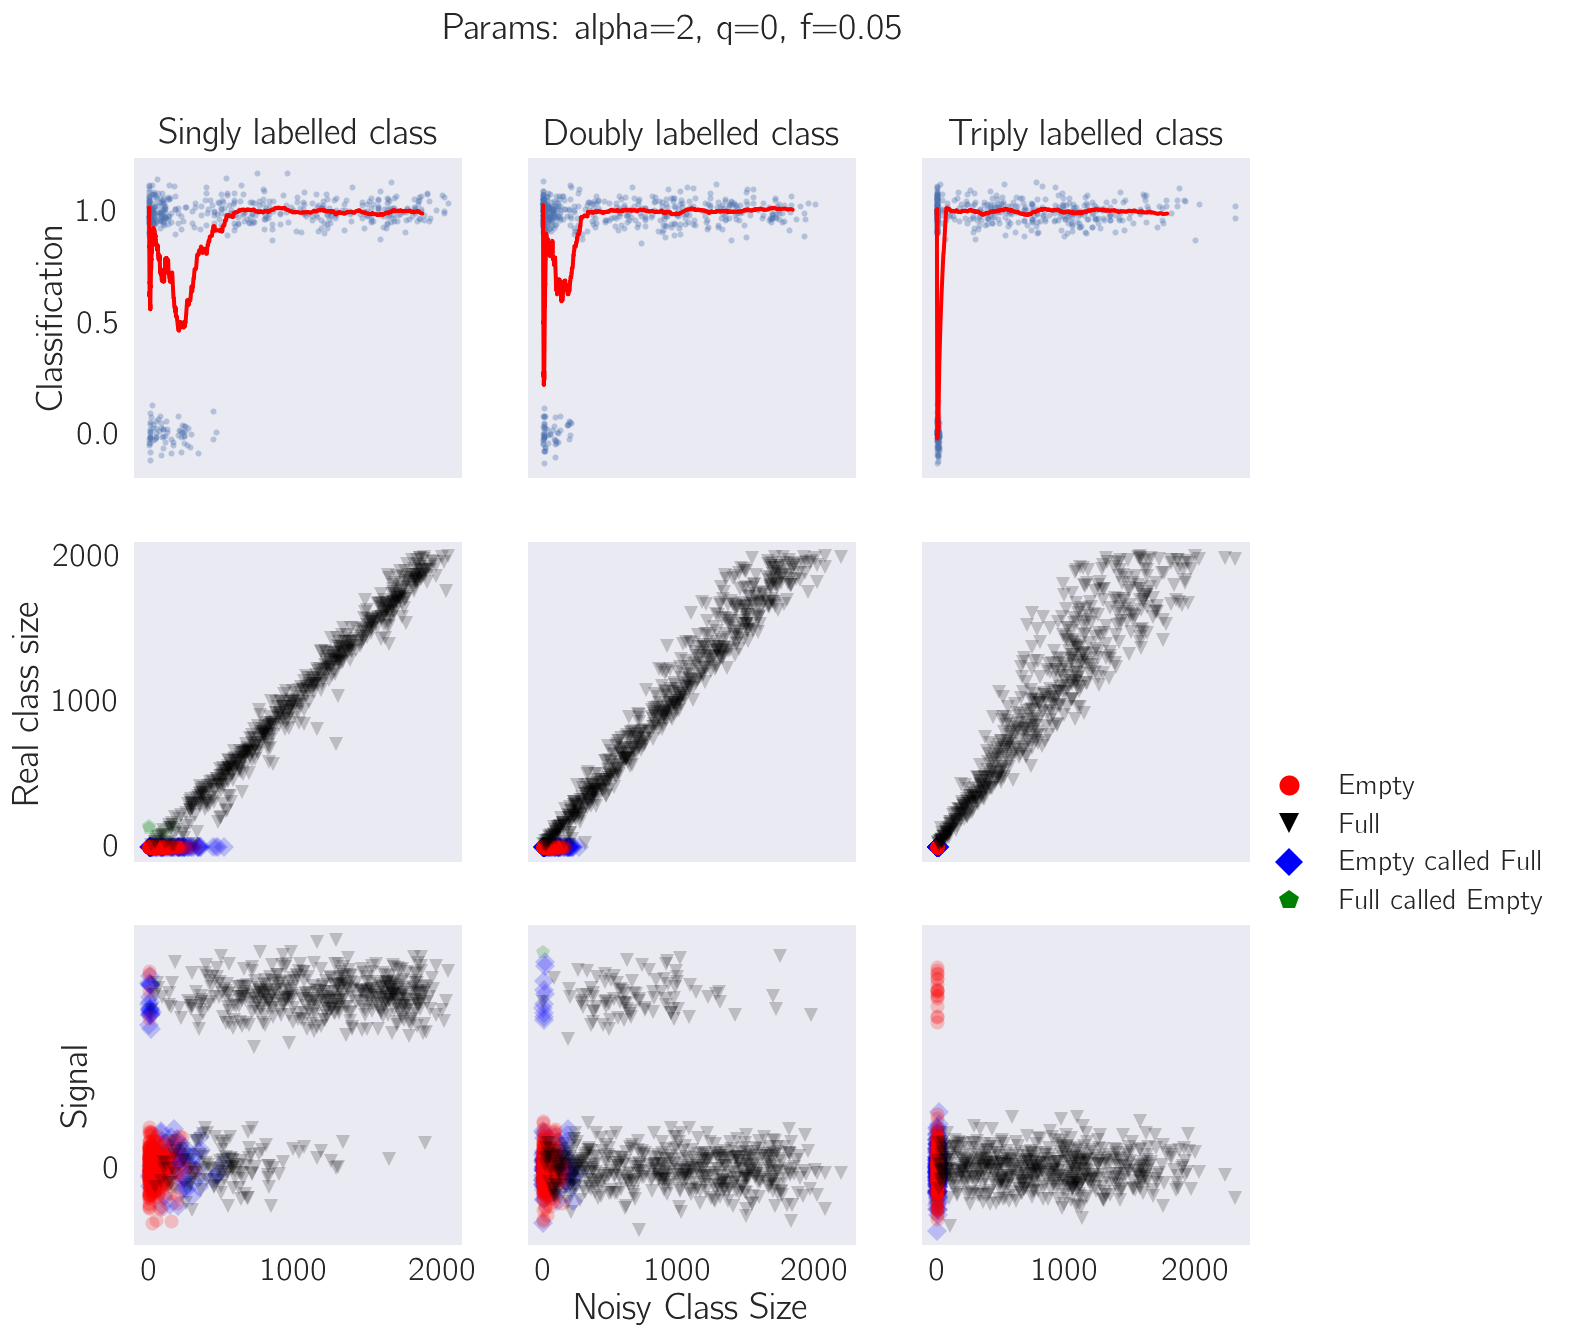

In [29]:
fig, ax = study(2, 0, 0.05)

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.88                0.98                0.99                
Empty               0.86                0.7                 0.65                


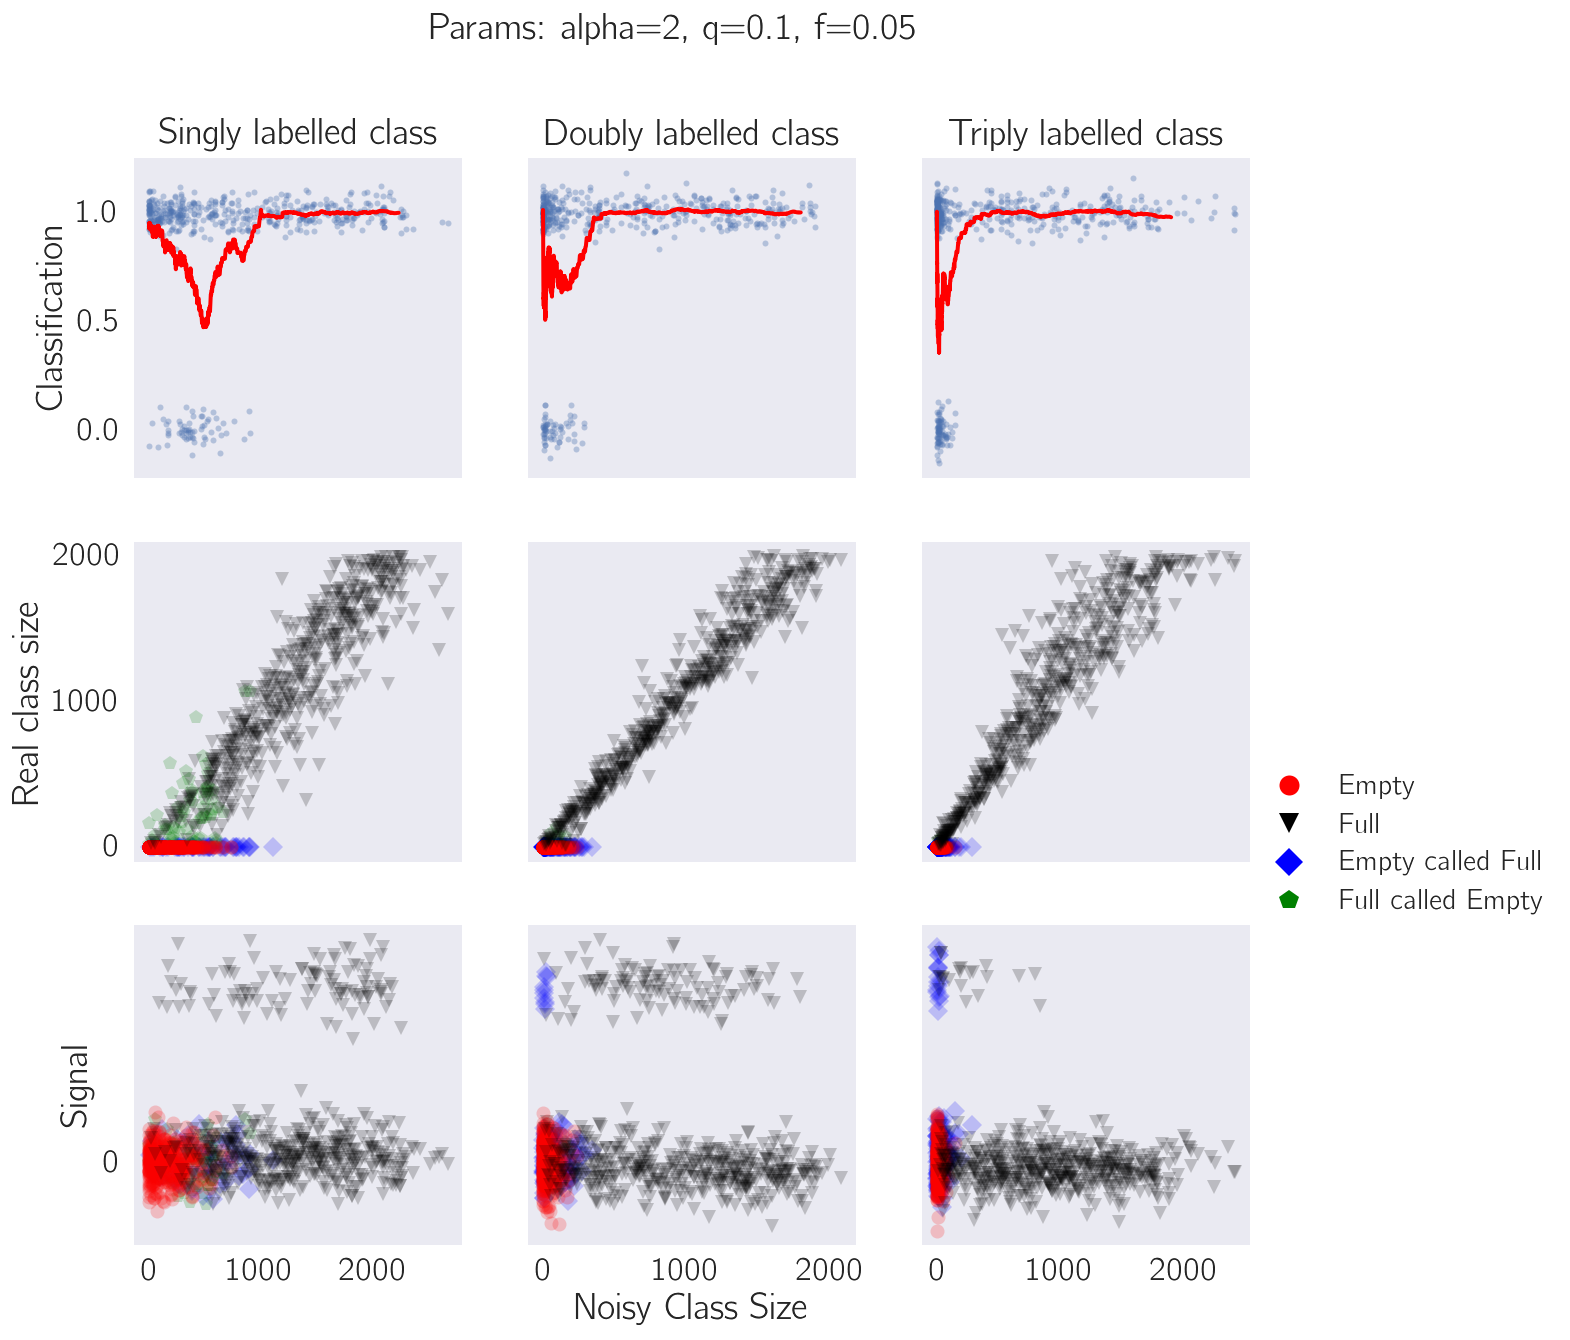

In [30]:
fig, ax = study(2, 0.1, 0.05)

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.75                0.98                0.99                
Empty               0.83                0.71                0.71                


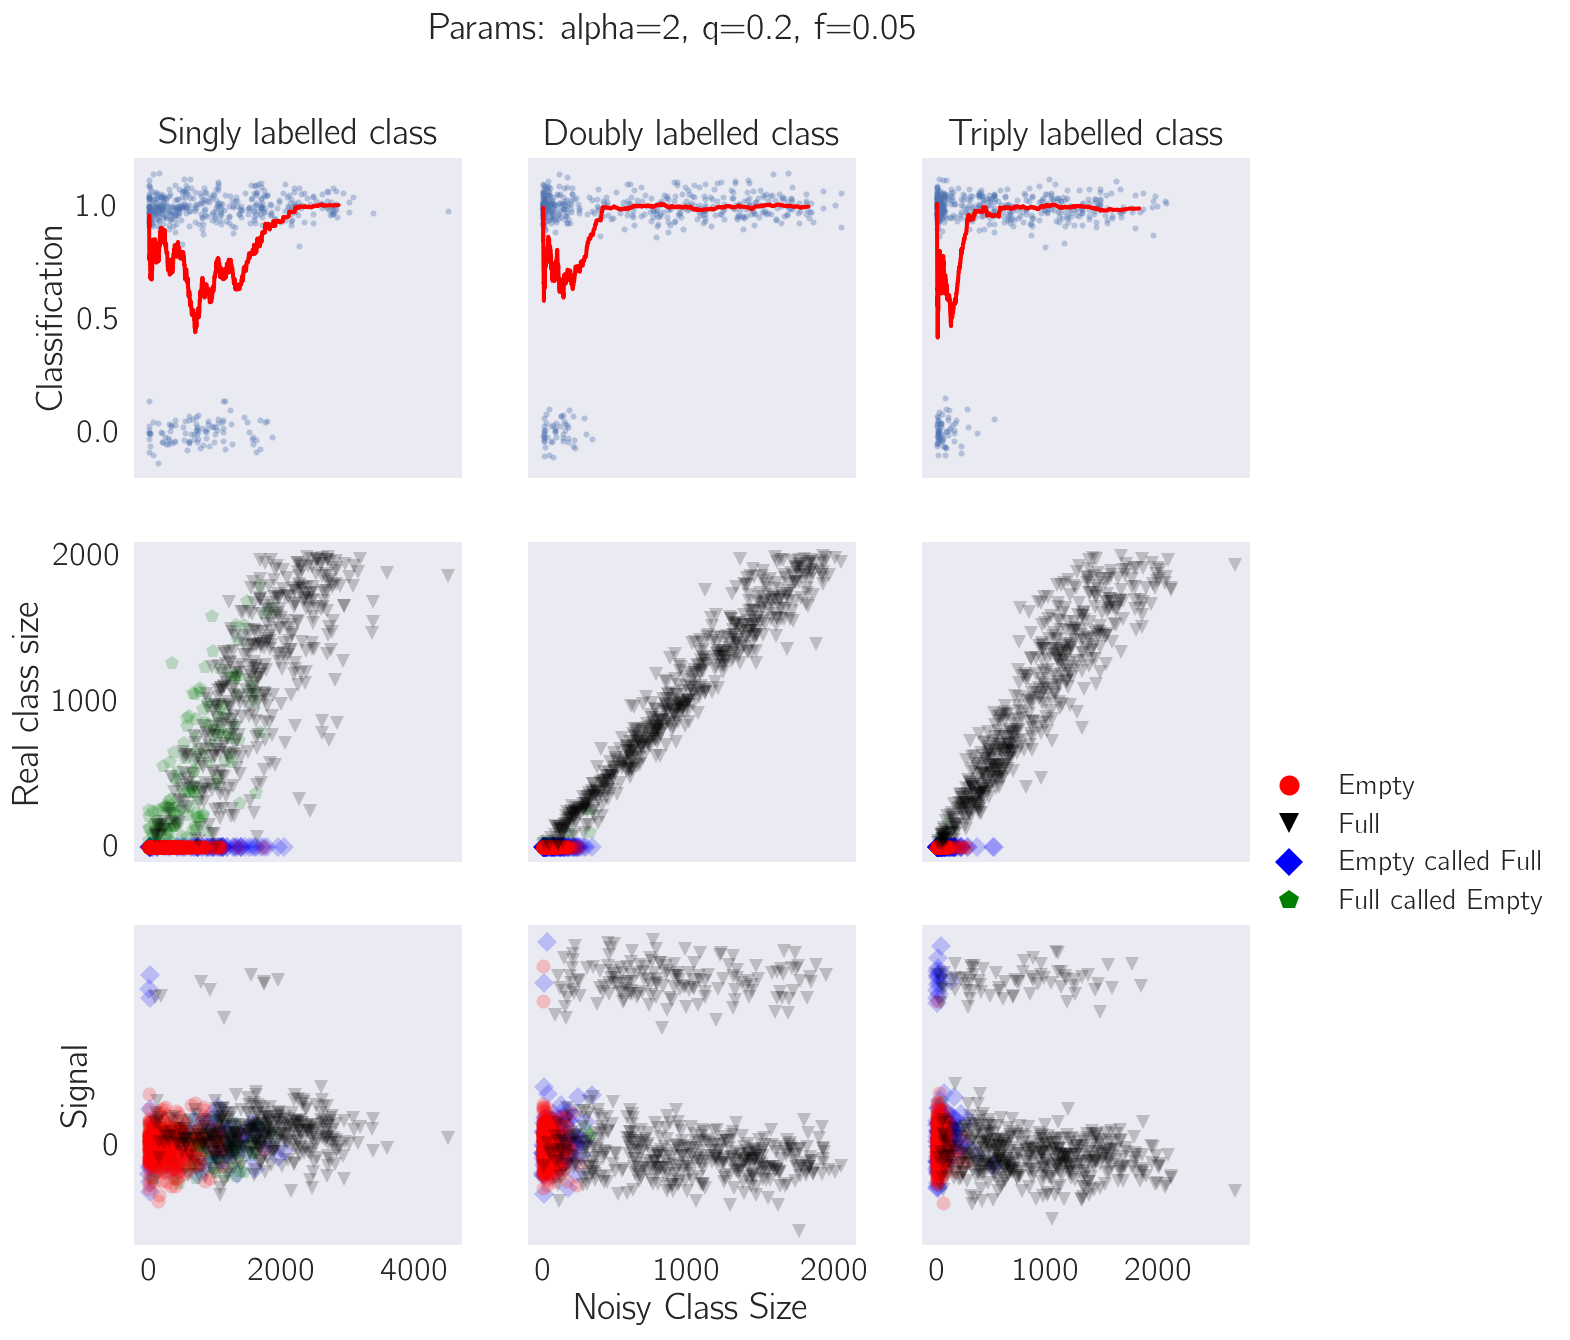

In [31]:
fig, ax = study(2, 0.2, 0.05)

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.9                 0.98                0.98                
Empty               0.77                0.67                0.65                


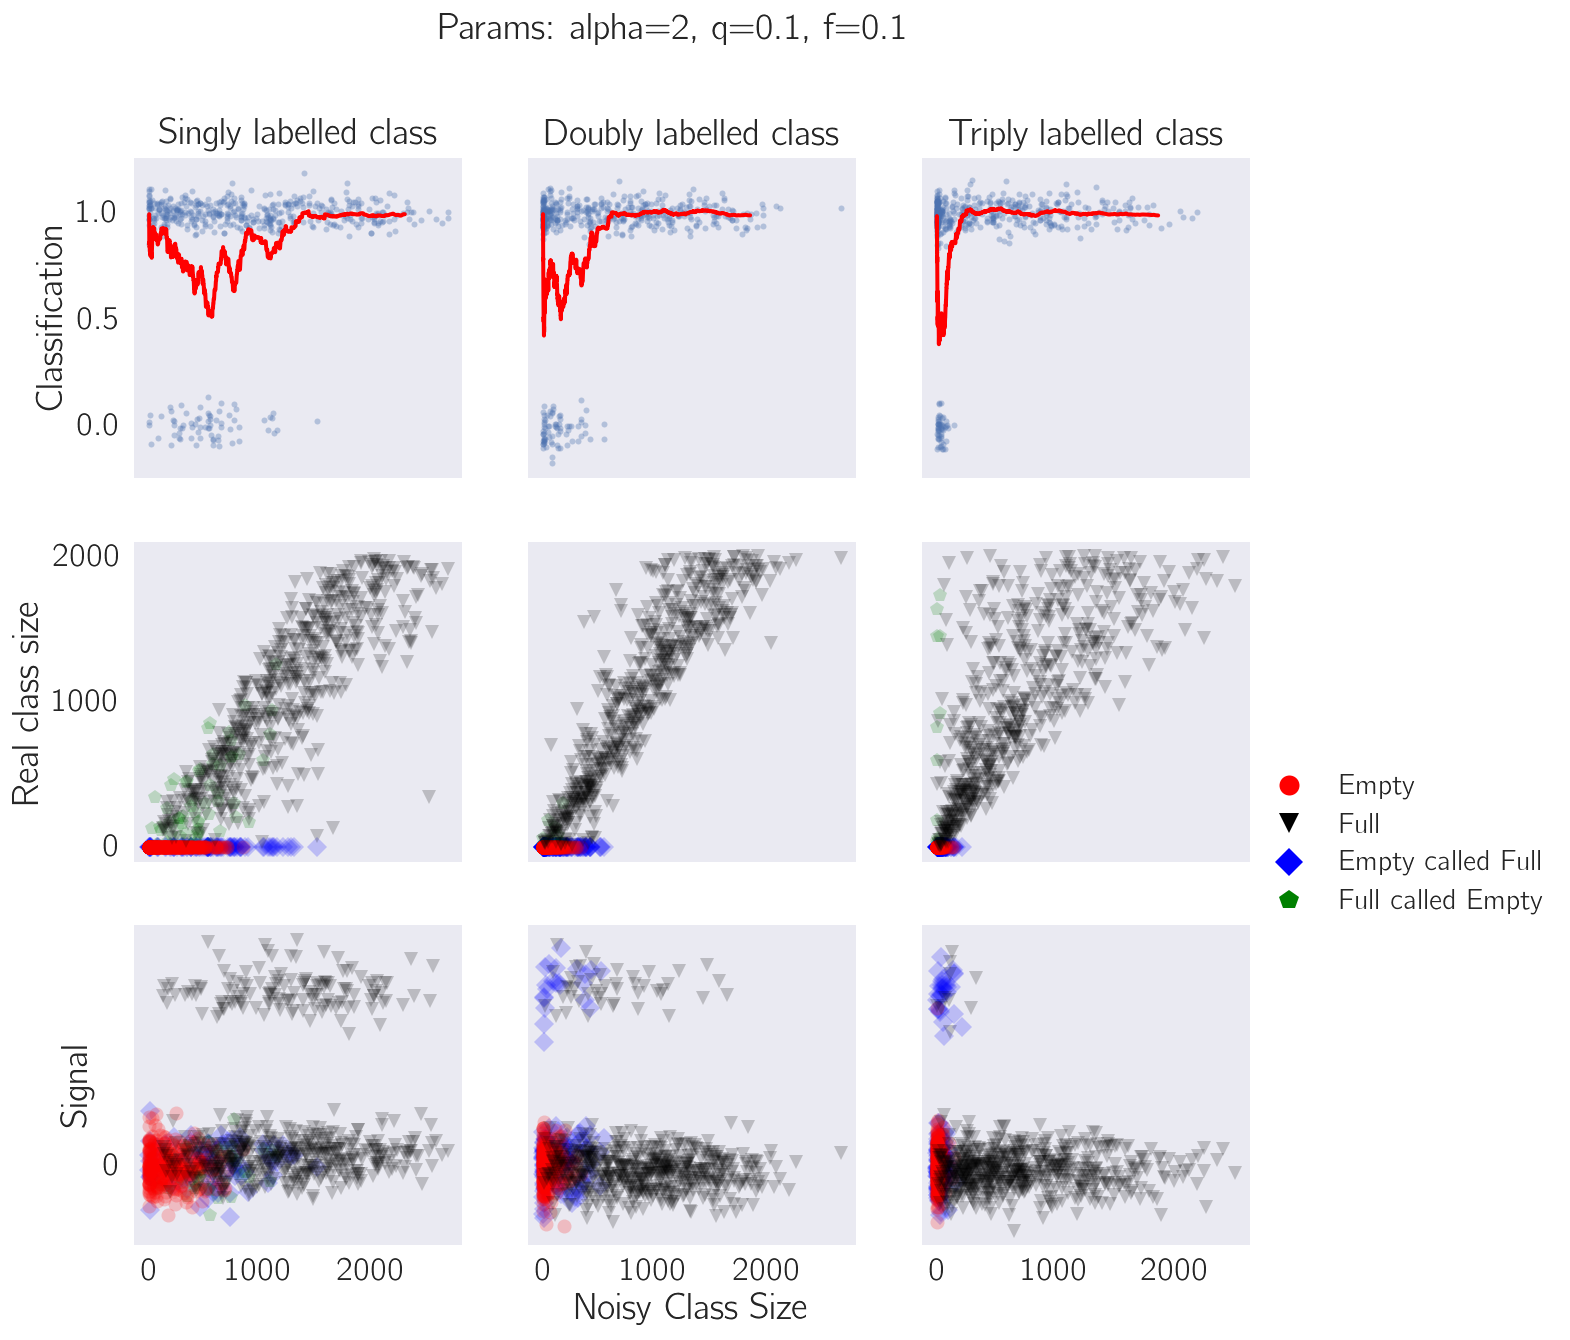

In [32]:
fig, ax = study(2, 0.1, 0.1)

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.56                0.96                0.99                
Empty               0.98                0.84                0.84                


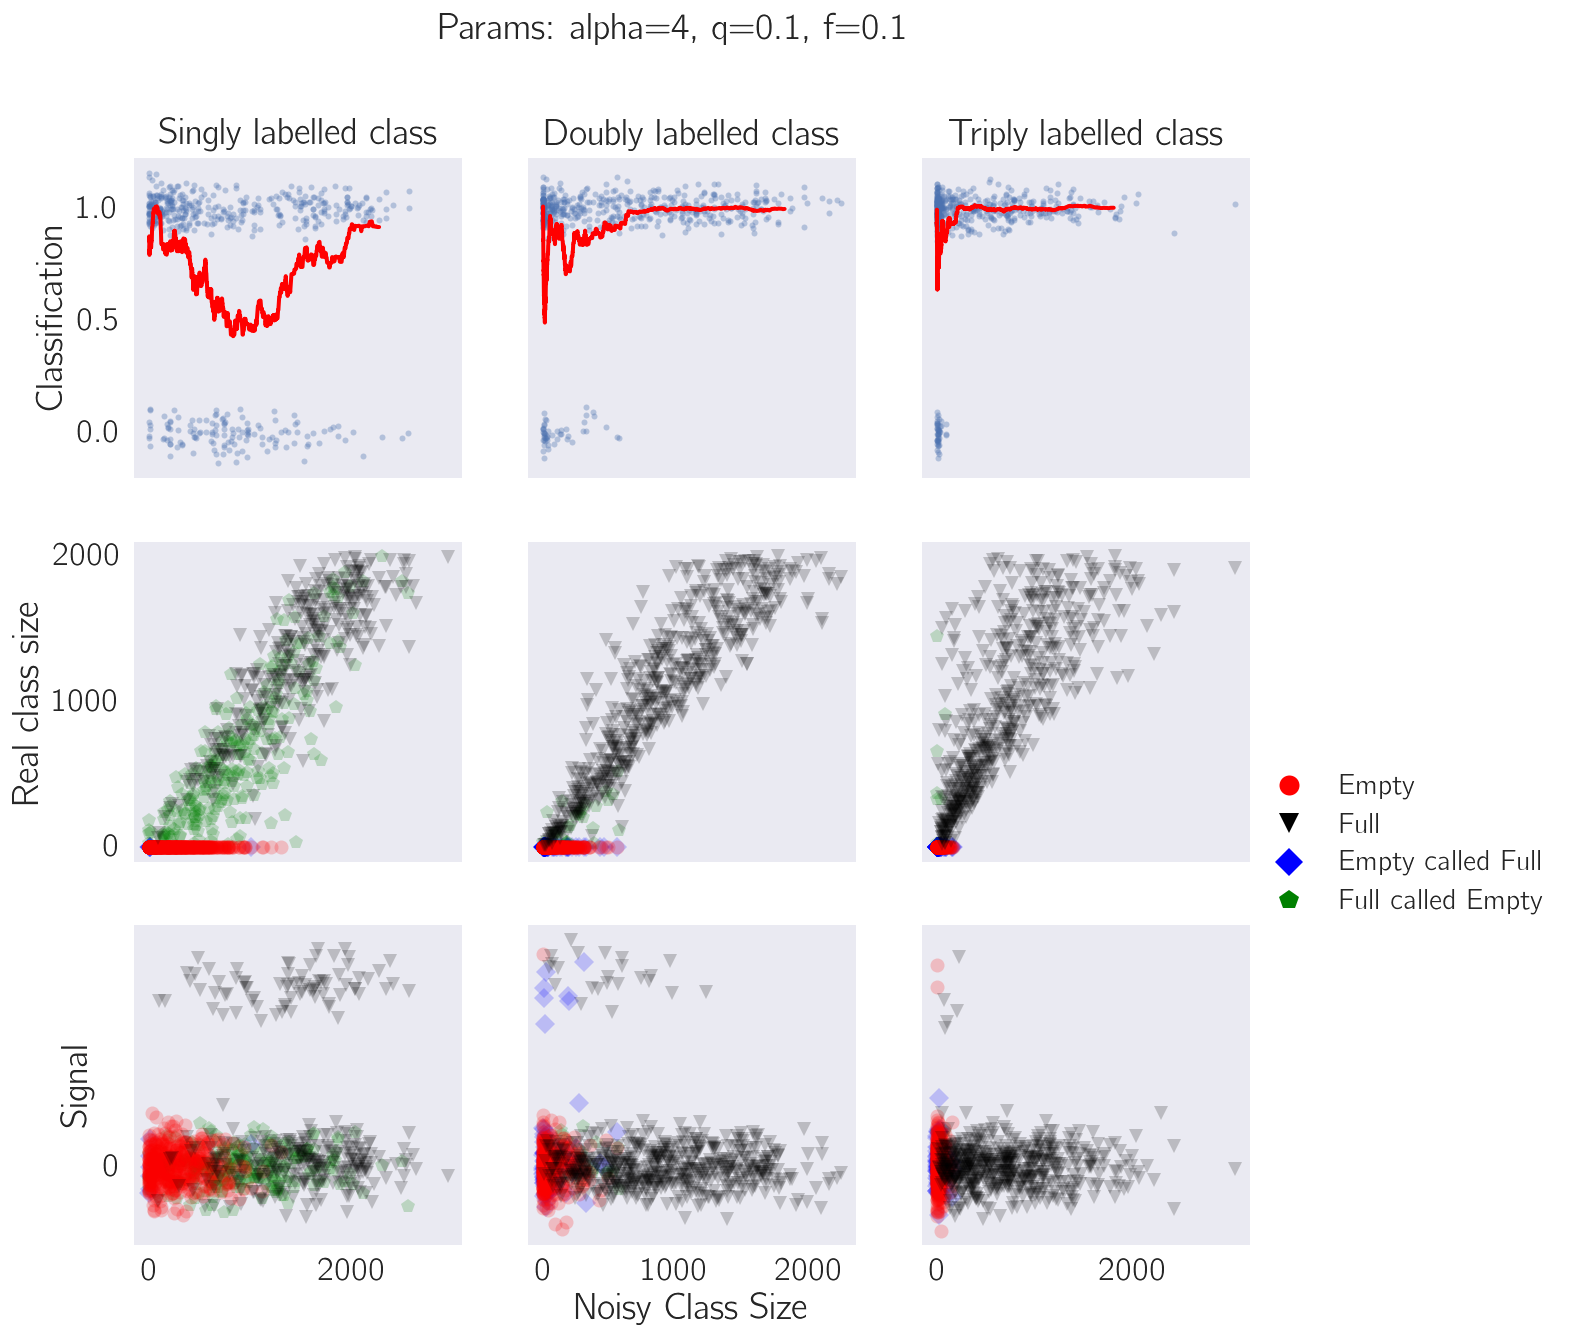

In [34]:
fig, ax = study(4, 0.1, 0.1)

fraction of categories correctly classified:
category            M100                M110                M111                
Full                0.73                0.94                0.9                 
Empty               0.92                0.69                0.72                


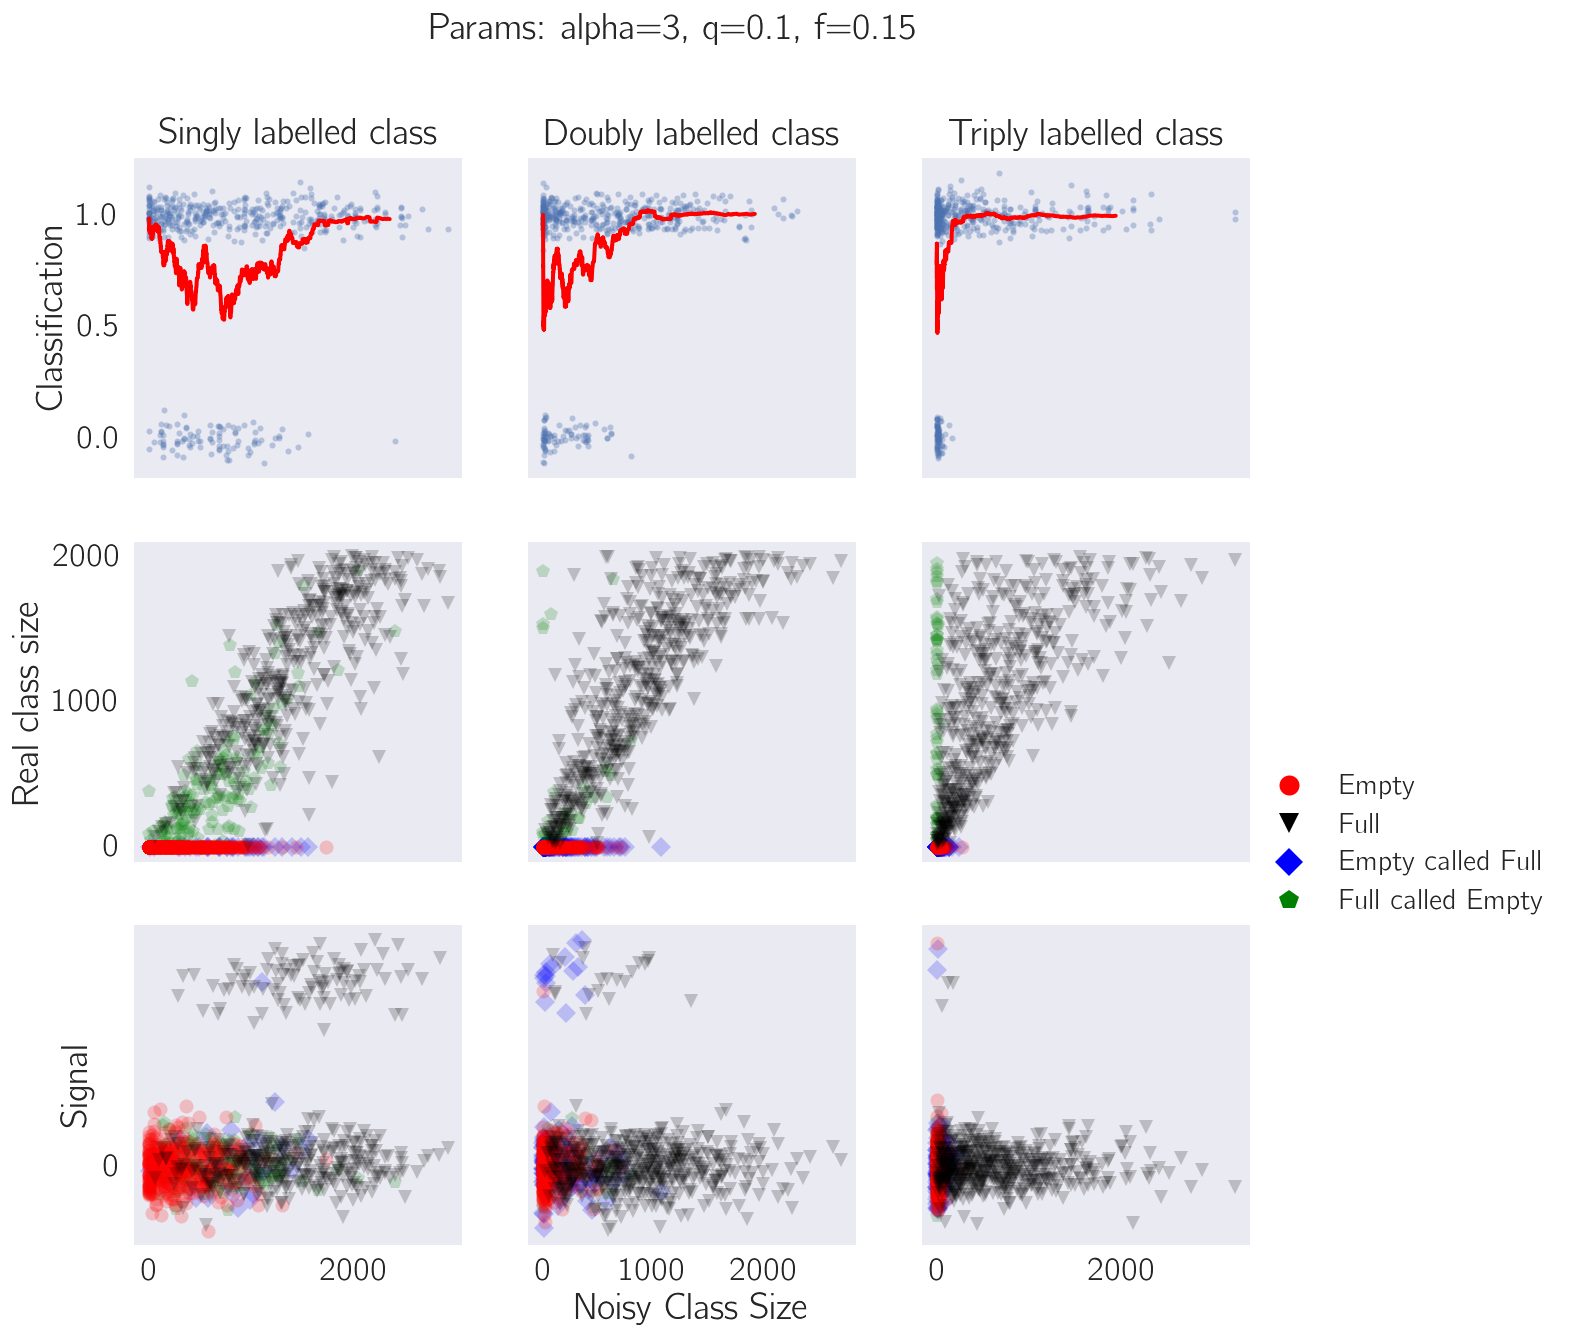

In [20]:
fig, ax = study(3, 0.1, 0.15)

In [92]:
alpha=3

In [99]:
N_T = 21954
M_obs = pheno.Model(2800, 481, 2214, N_T, 1800, 78, 1226, 106, 720, 57, 242, fn=0, fp=0)
k_min = (0, 0, 0, 0, 0, 0, 242)
final = iterate(M_obs, 2800, 481, 2214, N_T - 242, k_min, alpha=alpha, fp=0.1, fn=0.05)
chi_final = ((M_obs.M - (final.M + final.fps + final.fns))**2).sum()
final.accepted
print(final.accepted)
print(chi_final.sum())

[1800    0 1226  106  720   57  242]
255084.040267


In [101]:
N_T = 21954
M_obs = pheno.Model(2800, 481, 2214, N_T, 1800, 78, 1226, 106, 720, 57, 242, fn=0, fp=0)
k_min = (0, 0, 0, 0, 0, 0, 242)
final = iterate(M_obs, 2800, 481, 2214, N_T - 242, k_min, alpha=alpha, fp=0.1, fn=0.1)
chi_final = ((M_obs.M - (final.M + final.fps + final.fns))**2).sum()
print(final.accepted)
print(chi_final.sum())

[1800    0 1226  106  720    0  242]
100650.47535


In [102]:
N_T = 21954
M_obs = pheno.Model(2800, 481, 2214, N_T, 1800, 78, 1226, 106, 720, 57, 242, fn=0, fp=0)
k_min = (0, 0, 0, 0, 0, 0, 242)
final = iterate(M_obs, 2800, 481, 2214, N_T - 242, k_min, alpha=alpha, fp=0.1, fn=0.15)
chi_final = ((M_obs.M - (final.M + final.fps + final.fns))**2).sum()/((final.M + final.fps + final.fns))
print(final.accepted)
print(chi_final.sum())

[1800    0 1226    0  720    0  242]
4212.48094682


In [104]:
N_T = 21954
M_obs = pheno.Model(2800, 481, 2214, N_T, 1800, 78, 1226, 106, 720, 57, 242, fn=0, fp=0)
k_min = (0, 0, 0, 0, 0, 0, 242)
final = iterate(M_obs, 2800, 481, 2214, N_T - 242, k_min, alpha=alpha, fp=0.1, fn=0.2)
chi_final = ((M_obs.M - (final.M + final.fps + final.fns))**2).sum()/((final.M + final.fps + final.fns))
print(final.accepted)
print(chi_final.sum())

[1800    0 1226    0  720    0  242]
7446.53944867


In [103]:
# reclassified
M_final = pheno.Model(2800, 481-78, 2214, N_T, 1800, 0, 1226, 0, 720, 0, 415, fp=0.1, fn=0.1)
M_final.signal_threshold(alpha)
M_final.test_classes(M_obs.M)
chi_refined = (M_obs.M - (M_final.M + M_final.fps + M_final.fns))**2/((M_final.M + M_final.fps + M_final.fns))
print(final.accepted)
print(chi_refined.sum())

[1800    0 1226    0  720    0  242]
181.06298418
